In [1]:
%load_ext autoreload
%autoreload 2

# Init

In [2]:
import json
import sys
import re
import pickle as pkl
from pathlib import Path
from pprint import pprint
from collections import defaultdict
sys.path.append("../src")

import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

import constants
from evaluate import score, chart
from gen.util import read_data, write_jsonl

# Evaluate

In [3]:
baseline_default = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/feveronly/baseline")
cfever_tuned = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/fever_cfever/baseline")

sf_actual_sampled = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/fever2-sample/data/scifact/scifact_all_titleid.ns.pages.p1.jsonl"))
sf_actual = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-scifact/scifact_all_titleid.jsonl"))

In [4]:
eval_d = {}

for parent_path in [baseline_default, cfever_tuned]:
    for parent in parent_path.iterdir():
        model_name = parent.stem
        for prediction_file in parent.glob("pred.*.jsonl"):
            pred = read_data(prediction_file)
            res = score.FEVERScorer(sf_actual_sampled, pred, oracle_ir="oracle" in model_name, oracle_rte=False, max_evidence=None)
            eval_d[model_name] = res
            
with open("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/fever_cfever/baseline/baselin_cfever-tuned_predict-sf.pkl", "wb") as fn:
    pkl.dump(eval_d, fn)

In [4]:
with open("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/fever_cfever/baseline/baselin_cfever-tuned_predict-sf.pkl", "rb") as fn:
    eval_d = pkl.load(fn)

## IR-RTE

In [5]:
for k, v in eval_d.items():
    print(k, "\n")
    print(v.classification_report)
    print("\n")

p5s5_default_model 

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.38      0.06      0.11       416
        REFUTES       0.38      0.14      0.21       237
       SUPPORTS       0.43      0.90      0.58       456

       accuracy                           0.42      1109
      macro avg       0.40      0.37      0.30      1109
   weighted avg       0.40      0.42      0.32      1109



oracle_default_model 

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.64      0.51      0.57       416
        REFUTES       0.30      0.22      0.25       237
       SUPPORTS       0.55      0.73      0.63       456

       accuracy                           0.54      1109
      macro avg       0.49      0.48      0.48      1109
   weighted avg       0.53      0.54      0.52      1109



02_oracle_cfever-keep_vocab-15epoch 

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.08      0.03      0.05      

In [15]:
df_rte_metrics = []
for k, v in eval_d.items():
    df_rte_metrics.append({"model": k})
    df_rte_metrics[-1].update(v.score_to_dict())
pd.DataFrame(df_rte_metrics)

,model,fever_score,evidence_accuracy,evidence_precision,evidence_recall,evidence_f1,document_precision,document_recall,document_f1
0,p5s5_default_model,0.284040,0.424707,0.158466,0.629149,0.253166,0.320563,0.806157,0.458719
1,oracle_default_model,0.536519,0.536519,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,02_oracle_cfever-keep_vocab-15epoch,0.342651,0.342651,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,01_p9s8_cfever-extend_vocab-9epoch,0.292155,0.418395,0.114616,0.678211,0.196092,0.195587,0.822391,0.316016
4,02_p5s4_cfever-keep_vocab-15epoch,0.354373,0.427412,0.173761,0.568543,0.266173,0.356782,0.765272,0.486671
5,01_oracle_cfever-extend_vocab-9epoch,0.420198,0.420198,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check if models are making random decisions

In [9]:
baseline_p5s5_labels = read_data(baseline_default / "p5s5_default_model" / "predstage" / "labels.scifact_all_test.jsonl")
keep_p5s4_labels = read_data(cfever_tuned / "02_p5s4_cfever-keep_vocab-15epoch" / "predstage" / "labels.scifact_all_test.jsonl")
extend_p9s8_labels = read_data(cfever_tuned / "01_p9s8_cfever-extend_vocab-9epoch" / "predstage" / "labels.scifact_all_test.jsonl")

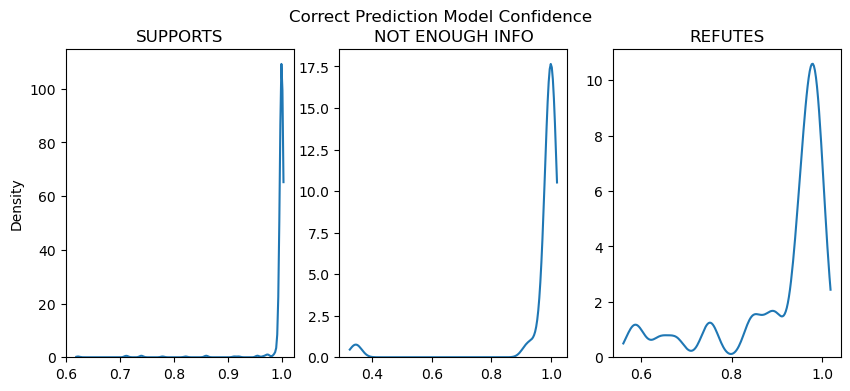

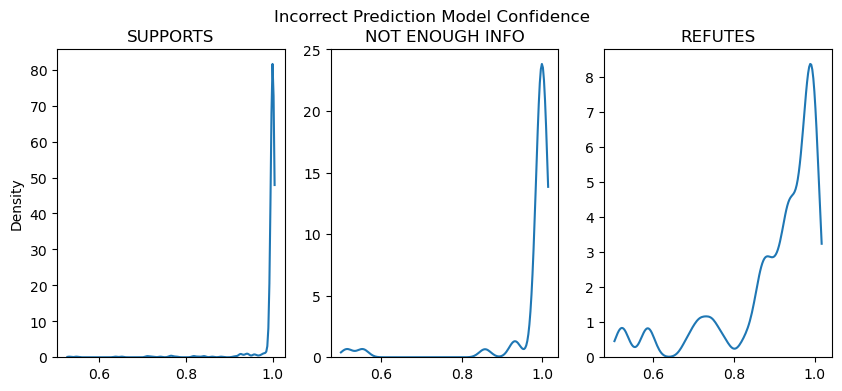

In [87]:
ctmp, itmp = chart.plot_model_confidence(sf_actual, baseline_p5s5_labels)

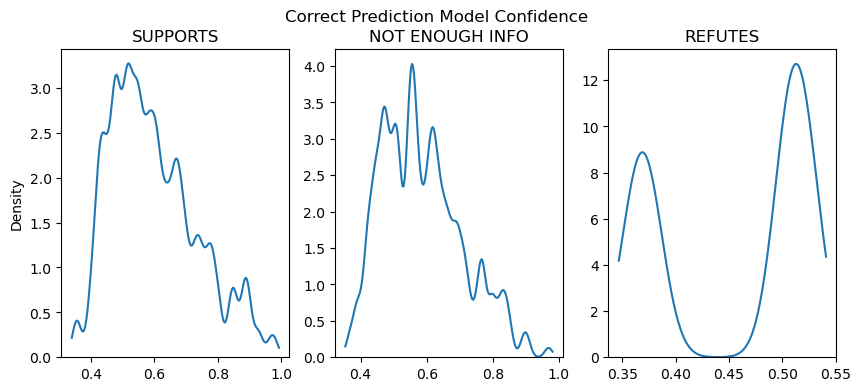

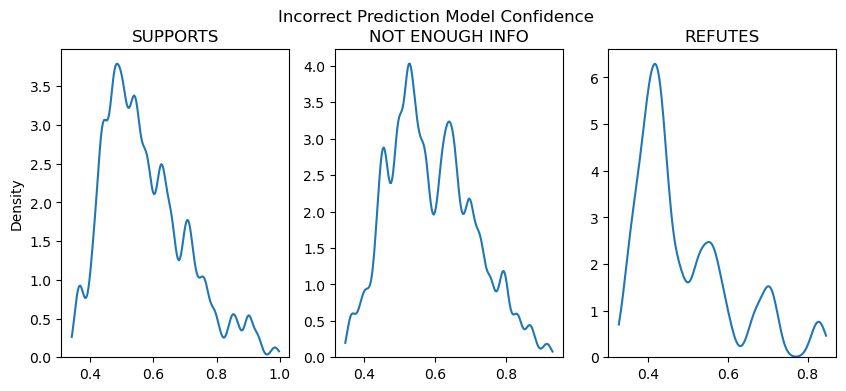

In [89]:
keep_correct, keep_incorrect = chart.plot_model_confidence(sf_actual, keep_p5s4_labels)

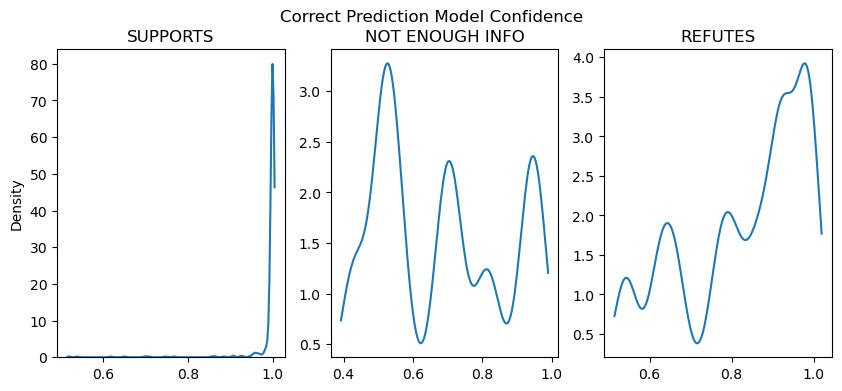

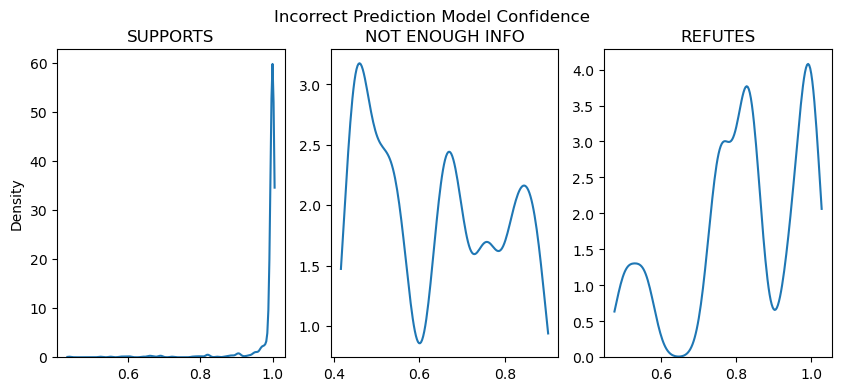

In [88]:
extend_correct, extend_incorrect = chart.plot_model_confidence(sf_actual, extend_p9s8_labels)